# Projet Fil Rouge : Classification des commentaires toxiques

In [29]:
import pandas as pd
import numpy as np
import configparser
import seaborn as sns
import matplotlib.pyplot as plt
#import upsetplot
sns.set_style("ticks")
from wordcloud import WordCloud, STOPWORDS

In [3]:
config = configparser.ConfigParser()
config.read('./config.cfg')
DataTrain = pd.read_csv(config['FILES']['TRAIN'])
DataTest = pd.read_csv(config['FILES']['TEST'])
DataSample = pd.read_csv(config['FILES']['SUBMIT'])

## Statistiques descriptives

Le jeu de données Train comporte 159571 observations de 8 variables :  
* ID   
* comment_text (le commentaire)  
* toxic (binaire indiquant si le commentaire est toxique)
* severe_toxic (binaire indiquant si le commentaire est extrêmement toxique)
* obscene (binaire indiquant si le commentaire est obscène)
* threat (binaire indiquant si le commentaire est une menace)
* insult (binaire indiquant si le commentaire est une insulte)
* identity_hate (binaire indiquant si le commentaire est raciste)

In [4]:
DataTrain.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Maintenanet nous allons regarder le nombre d'occurences de chaque label.

Nombre total de commentaires =  159571
Nombre de commentaires clean=  143346
Total tags = 35098


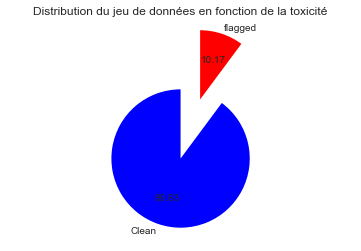

In [5]:
x=DataTrain.iloc[:,2:].sum()
#On tag les commentaires sans label comme "clean"
rowsums=DataTrain.iloc[:,2:].sum(axis=1)
DataTrain['clean']=(rowsums==0)
DataTrain['flagged']=(rowsums!=0)
#le nombre de commentaires clean
DataTrain['clean'].sum()
print("Nombre total de commentaires = ",len(DataTrain))
print("Nombre de commentaires clean= ",DataTrain['clean'].sum())
print("Total tags =",x.sum())

explodeTuple = (0.1, 0.8)
values = [DataTrain['clean'].sum(),DataTrain['flagged'].sum()]
fig, axes = plt.subplots()
axes.pie(values, labels=('Clean','flagged'),autopct='%1.2f',startangle=90, explode= explodeTuple, colors=('blue','red'))
axes.axis('equal')
plt.title("Distribution du jeu de données en fonction de la toxicité")
plt.savefig("pieplot.png", dpi =200)
plt.show()

On observe que les commentaires flagués constituent 10.17 % des commentaires.

In [20]:
one_label = DataTrain[rowsums==1]
print('Percentage of flagged comments with one label : {0:.3f}%'.format(len(one_label)/len(DataTrain[rowsums!=0])))
two_labels = DataTrain[rowsums==2]
print('Percentage of flagged comments with two labels : {0:.3f}%'.format(len(two_labels)/len(DataTrain[rowsums!=0])))
multiple_labels = DataTrain[(rowsums>=3) & (rowsums<6)]
print('Percentage of flagged comments with multiple labels : {0:.3f}%'.format(len(multiple_labels)/len(DataTrain[rowsums!=0])))
all_labels = DataTrain[rowsums==6]
print('Percentage of flagged comments with all labels : {0:.3f}%'.format(len(all_labels)/len(DataTrain[rowsums!=0])))

Percentage of flagged comments with one label : 0.392%
Percentage of flagged comments with two labels : 0.214%
Percentage of flagged comments with multiple labels : 0.392%
Percentage of flagged comments with all labels : 0.002%


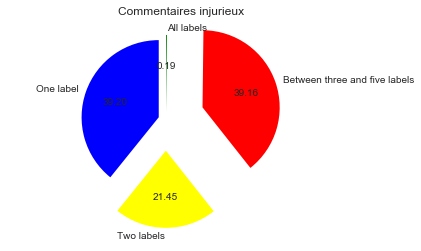

In [21]:
explodeTuple = (0.1, 0.4,0.5,0.1)
values = [len(one_label),len(two_labels),len(multiple_labels),len(all_labels)]
fig, axes = plt.subplots()
axes.pie(values, labels=('One label','Two labels','Between three and five labels','All labels'),autopct='%1.2f',startangle=90,  explode= explodeTuple,colors=('blue','yellow','red','green'))
axes.axis('equal')
plt.title("Commentaires injurieux")
plt.savefig("pieplot2.png", dpi =200)
plt.show()

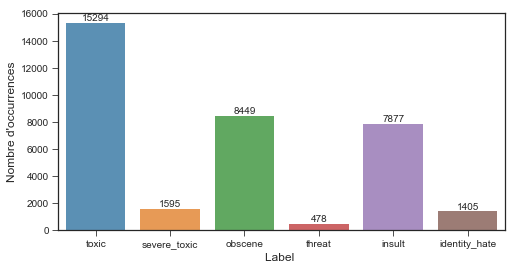

In [22]:
x=DataTrain.iloc[:,2:8].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("")
plt.ylabel('Nombre d\'occurrences', fontsize=12)
plt.xlabel('Label ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.savefig('Occurences.png', dpi = 200)
plt.show()


In [23]:
merge=pd.concat([DataTrain.iloc[:,0:2],DataTest.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [24]:
## Indirect features
import re
import string
#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
#df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/Users/cherifabass/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [25]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [26]:
#serperate train and test features
train_feats=df.iloc[0:len(DataTrain),]
test_feats=df.iloc[len(DataTrain):,]
#join the tags
train_tags=DataTrain.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

/Users/cherifabass/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


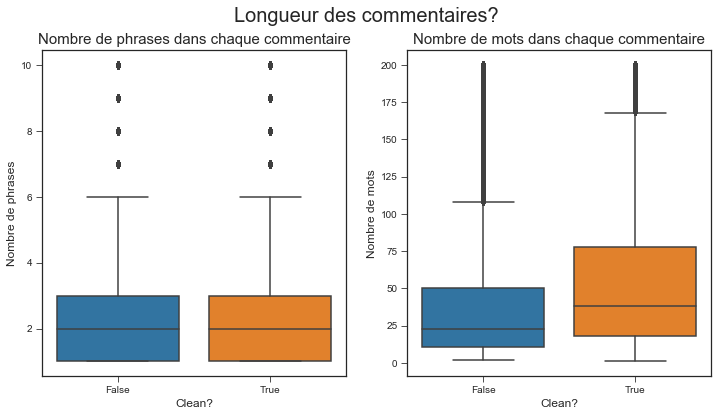

In [27]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Longueur des commentaires?",fontsize=20)
sns.boxplot(y='count_sent',x='clean', data=train_feats)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('Nombre de phrases', fontsize=12)
plt.title("Nombre de phrases dans chaque commentaire", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.boxplot(y='count_word',x='clean', data=train_feats)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('Nombre de mots', fontsize=12)
plt.title("Nombre de mots dans chaque commentaire", fontsize=15)
plt.savefig('Fig1.png', dpi = 200)
plt.show()

On voit que les commentaires toxiques sont les plus fréquents.

Maintenant nous allons nous intéresser aux longueurs des commentaires. Pour cela on crée une variable *comment_length* qui nous donnera le nombre de mots dans chaque commentaire.

In [28]:
DataTrain['comment_length_unclean']=DataTrain['comment_text'][rowsums>0].apply(lambda x: len(str(x).split()))
DataTrain['comment_length_clean']=DataTrain['comment_text'][rowsums==0].apply(lambda x: len(str(x).split()))
DataTrain['comment_length']=DataTrain['comment_text'].apply(lambda x: len(str(x).split()))

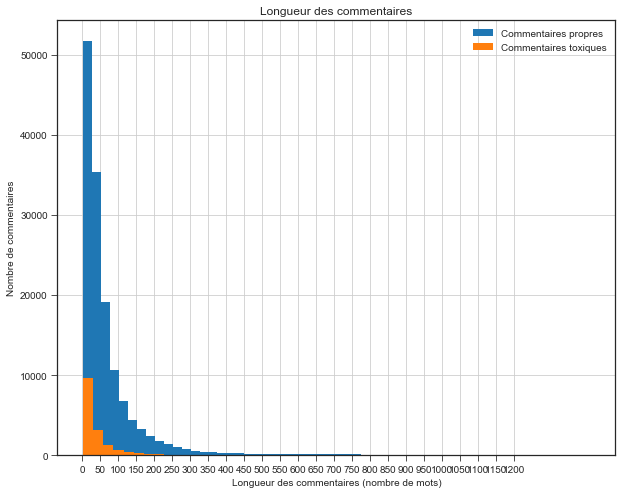

In [29]:
plt.figure(figsize=(10, 8))
#DataTrain['comment_length'].hist(bins=100)
DataTrain['comment_length_clean'].hist(bins=50)
DataTrain['comment_length_unclean'].hist(bins=50)
plt.title('Longueur des commentaires')
plt.xticks(np.arange(0, max(DataTrain['comment_length_clean']), 50))
plt.ylabel("Nombre de commentaires")
plt.xlabel("Longueur des commentaires (nombre de mots)")
plt.legend(["Commentaires propres","Commentaires toxiques"])
plt.savefig('cl_1.png', dpi = 200)
plt.show()


On voit sur l'histogramme précédent que la majorité des commentaires ont un nombre de mots entre 1 et 100.

Nous allons aussi regarder le nombre de mots en fonction du label. Pour cela on récupère pour chaque label les observations correspondantes.

In [30]:
Toxic = DataTrain[DataTrain["toxic"]==1]
SevereToxic = DataTrain[DataTrain["severe_toxic"]==1]
Obscene = DataTrain[DataTrain["obscene"]==1]
IdentityHate = DataTrain[DataTrain["identity_hate"]==1]
Threat = DataTrain[DataTrain["threat"]==1]
Insult = DataTrain[DataTrain["insult"]==1]

On voit sur les histogrammes précédents que le nombre de mots dans un commentaire ne dépend pas du label du commentaire.

Maintenant nous allons regarder les mots les plus fréquents de chaque label. Pour cela on récupère les commentaires associés à chaque label.

In [31]:
ToxicComments = DataTrain["comment_text"][DataTrain["toxic"]==1]
SevereToxicComments = DataTrain["comment_text"][DataTrain["severe_toxic"]==1]
ObsceneComments = DataTrain["comment_text"][DataTrain["obscene"]==1]
IdentityHateComments = DataTrain["comment_text"][DataTrain["identity_hate"]==1]
ThreatComments = DataTrain["comment_text"][DataTrain["threat"]==1]
InsultComments = DataTrain["comment_text"][DataTrain["insult"]==1]

Nous allons utiliser la bibliothèque WordCloud pour représenter les mots fréquents de chaque label.

In [32]:
from PIL import Image


In [ ]:
wave_mask = np.array(Image.open( "Toxic-Logo.jpg"))
wc = WordCloud(background_color="black", max_words=10000, 
               mask=wave_mask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(ToxicComments))
plt.figure(figsize=(10, 8))
plt.title("Most frequent words in toxic comments", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

In [ ]:
wave_mask = np.array(Image.open("obscene.jpg"))
wc = WordCloud(background_color="black", max_words=10000, 
               mask=wave_mask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(SevereToxicComments))
plt.figure(figsize=(10, 8))
plt.title("Most frequent words in Severly toxic comments", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

In [ ]:
wc = WordCloud(background_color="black", max_words=10000, 
               mask=wave_mask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(ObsceneComments))
plt.figure(figsize=(10, 8))
plt.title("Most frequent words in obscene comments", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

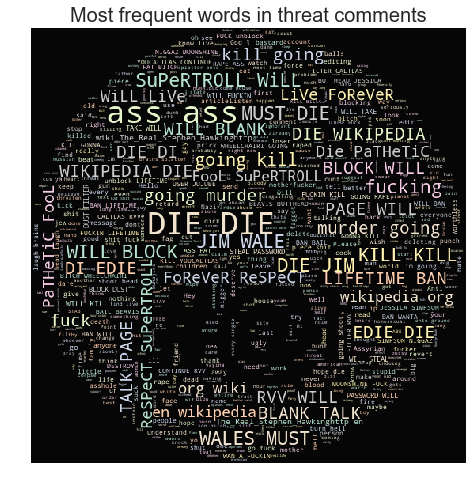

In [130]:
wc = WordCloud(background_color="black", max_words=10000, 
               mask=wave_mask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(ThreatComments))
plt.figure(figsize=(10, 8))
plt.title("Most frequent words in threat comments", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

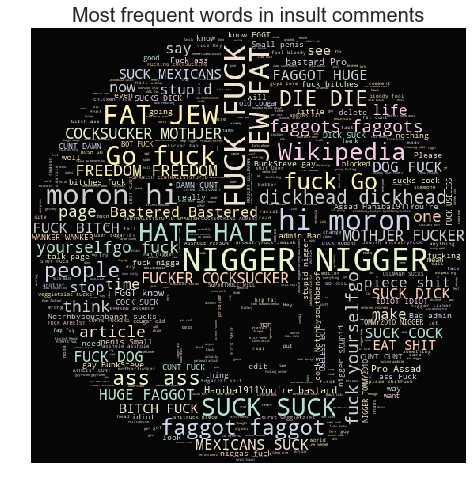

In [131]:
wc = WordCloud(background_color="black", max_words=10000, 
               mask=wave_mask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(InsultComments))
plt.figure(figsize=(10, 8))
plt.title("Most frequent words in insult comments", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

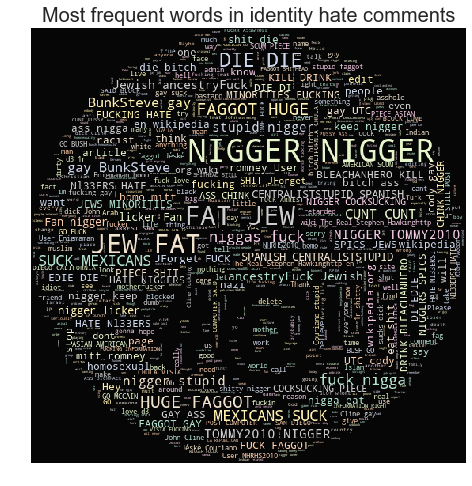

In [132]:
wc = WordCloud(background_color="black", max_words=10000, 
               mask=wave_mask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(IdentityHateComments))
plt.figure(figsize=(10, 8))
plt.title("Most frequent words in identity hate comments", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

On observe donc que certains mots sont présents dans tous les labels. Cela est dû au caractère familier de ces mots qui fait qu'elles sont toujours présentes peu importe le niveau de toxicité du commentaire. En revanche on remarque que certains mots ne sont présents que pour certains labels.

Maintenant que nous avons vu des wordclouds des mots les plus fréquents nous régarder les 20 mots les plus fréquents pour chaque label.

In [6]:
import collections
from nltk.corpus import stopwords
stop = stopwords.words('english')
without_stopwords = DataTrain['comment_text'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop]))

In [7]:
#Clean
x=without_stopwords[rowsums==0]
clean_words = collections.Counter(" ".join(without_stopwords).lower().split()).most_common(20)
#Toxic
x=without_stopwords[DataTrain['toxic']==1]
toxic_words = collections.Counter(" ".join(x).lower().split()).most_common(20)
#Obscne
x=without_stopwords[DataTrain['obscene']==1]
obscene_words=collections.Counter(" ".join(x).lower().split()).most_common(20)
#Sev Toxic
x=without_stopwords[DataTrain['severe_toxic']==1]
sev_toxic_words = collections.Counter(" ".join(x).lower().split()).most_common(20)
#ID hate
x=without_stopwords[DataTrain['identity_hate']==1]
id_hate_words = collections.Counter(" ".join(x).lower().split()).most_common(20)
#Insult
x=without_stopwords[DataTrain['insult']==1]
insult_words = collections.Counter(" ".join(x).lower().split()).most_common(20)
#Threat
x=without_stopwords[DataTrain['threat']==1]
threat_words = collections.Counter(" ".join(x).lower().split()).most_common(20)

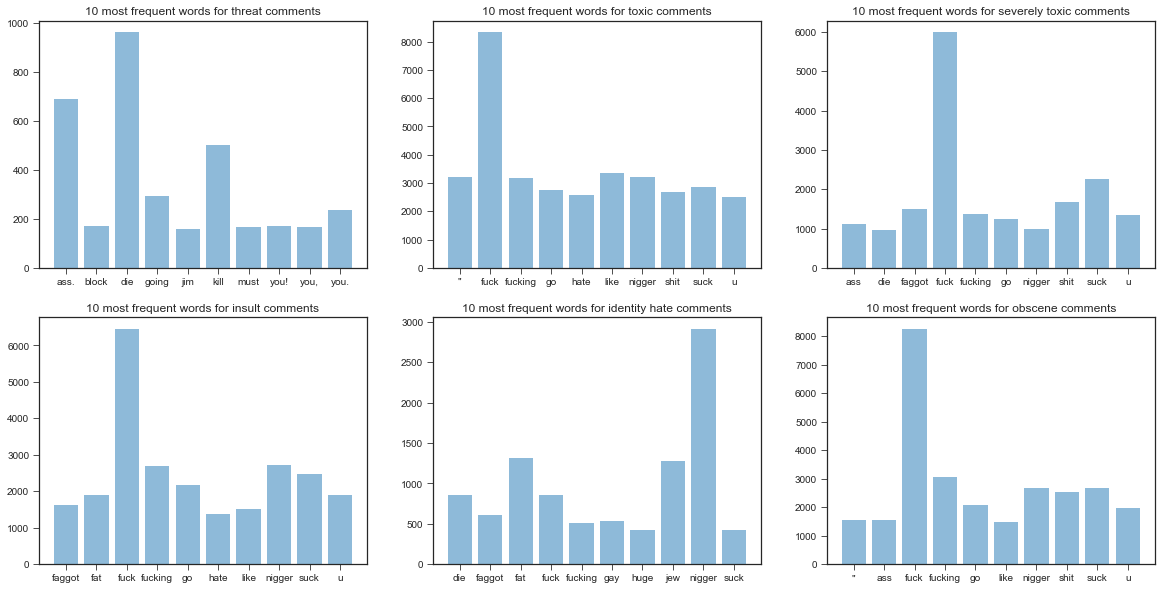

In [34]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.bar([threat_words[i][0] for i in range(10) ], [threat_words[i][1] for i in range(10) ], align='center', alpha=0.5)
plt.title("10 most frequent words for threat comments")

plt.subplot(2,3,2)
plt.bar([toxic_words[i][0] for i in range(10) ], [toxic_words[i][1] for i in range(10) ], align='center', alpha=0.5)
plt.title("10 most frequent words for toxic comments")

plt.subplot(2,3,3)
plt.bar([sev_toxic_words[i][0] for i in range(10) ], [sev_toxic_words[i][1] for i in range(10) ], align='center', alpha=0.5)
plt.title("10 most frequent words for severely toxic comments")

plt.subplot(2,3,4)
plt.bar([insult_words[i][0] for i in range(10) ], [insult_words[i][1] for i in range(10) ], align='center', alpha=0.5)
plt.title("10 most frequent words for insult comments")

plt.subplot(2,3,5)
plt.bar([id_hate_words[i][0] for i in range(10) ], [id_hate_words[i][1] for i in range(10) ], align='center', alpha=0.5)
plt.title("10 most frequent words for identity hate comments")

plt.subplot(2,3,6)
plt.bar([obscene_words[i][0] for i in range(10) ], [obscene_words[i][1] for i in range(10) ], align='center', alpha=0.5)
plt.title("10 most frequent words for obscene comments")
plt.savefig("10mostFrequentWords.png", dpi = 200)
plt.show()

In [300]:
df_words = pd.DataFrame(
    {'Clean': clean_words,
     'Toxic': toxic_words,
     'Severely toxic': sev_toxic_words,
      'Insult': insult_words,
       'Obscene': obscene_words,
       'Threat': threat_words,
    })


In [301]:
df_words

,Clean,Insult,Obscene,Severely toxic,Threat,Toxic
0,"("", 81755)","(fuck, 6452)","(fuck, 8255)","(fuck, 5992)","(die, 960)","(fuck, 8325)"
1,"(article, 39018)","(nigger, 2721)","(fucking, 3066)","(suck, 2269)","(ass., 688)","(like, 3365)"
2,"(would, 29058)","(fucking, 2696)","(suck, 2684)","(shit, 1681)","(kill, 501)","(nigger, 3223)"
3,"(page, 28731)","(suck, 2474)","(nigger, 2669)","(faggot, 1509)","(going, 294)","("", 3209)"
4,"(please, 27513)","(go, 2176)","(shit, 2537)","(fucking, 1372)","(you., 234)","(fucking, 3165)"
5,"(like, 26338)","(fat, 1901)","(go, 2078)","(u, 1349)","(you!, 169)","(suck, 2872)"
6,"(one, 24636)","(u, 1887)","(u, 1977)","(go, 1235)","(block, 169)","(go, 2768)"
7,"(-, 23412)","(faggot, 1618)","(ass, 1557)","(ass, 1103)","(you,, 168)","(shit, 2684)"
8,"(talk, 22839)","(like, 1503)","("", 1541)","(nigger, 999)","(must, 165)","(hate, 2587)"
9,"(wikipedia, 22438)","(hate, 1375)","(like, 1485)","(die, 972)","(jim, 158)","(u, 2495)"
